../newdata/dounambayapril2013.png
8


Loading data:   0%|          | 0/8 [00:00<?, ?it/s]

Loading data: 100%|██████████| 8/8 [00:00<00:00, 15.58it/s]


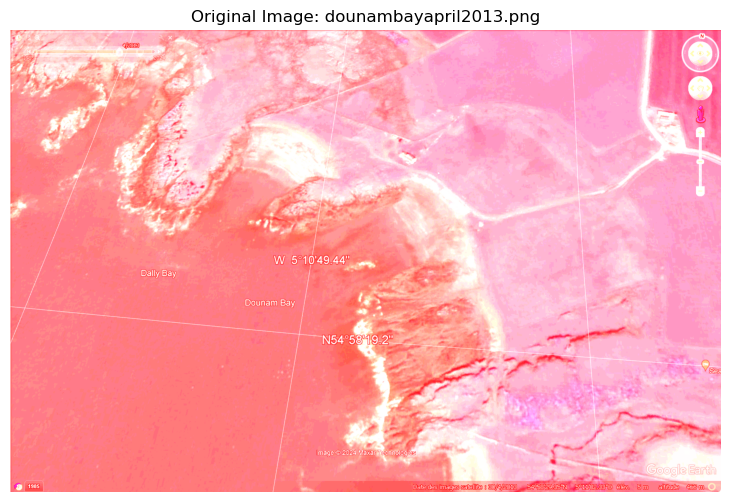

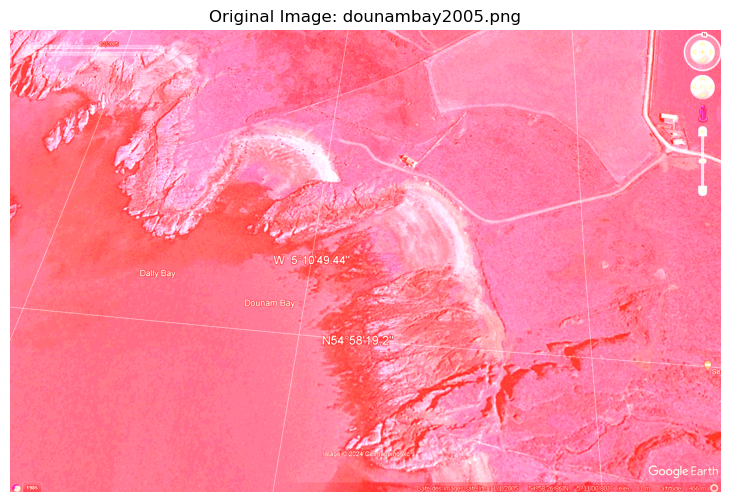

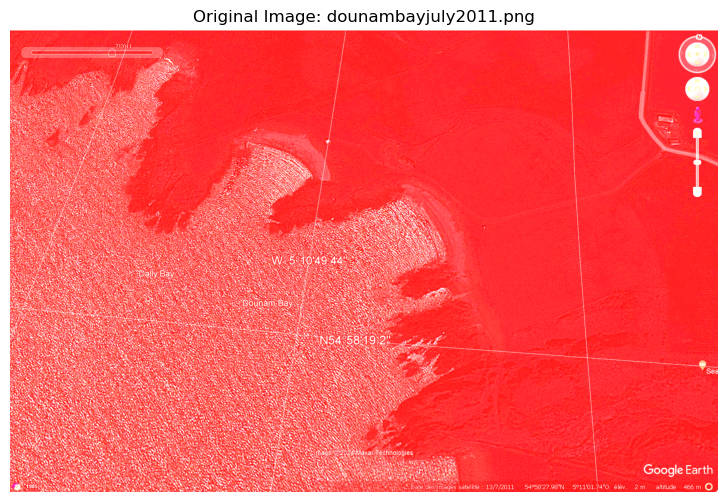

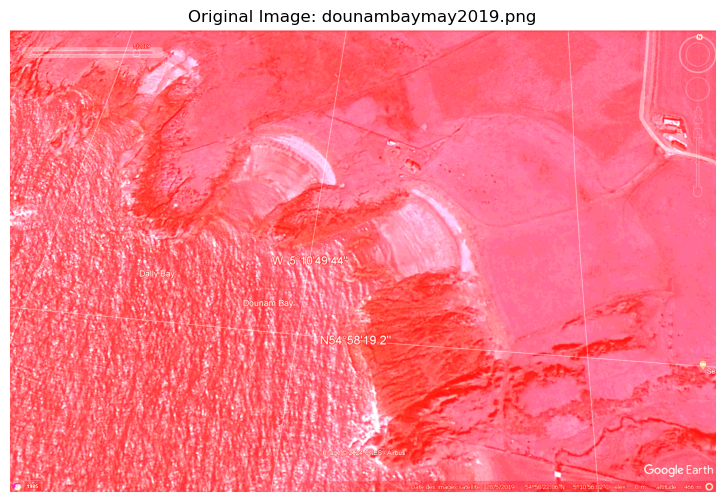

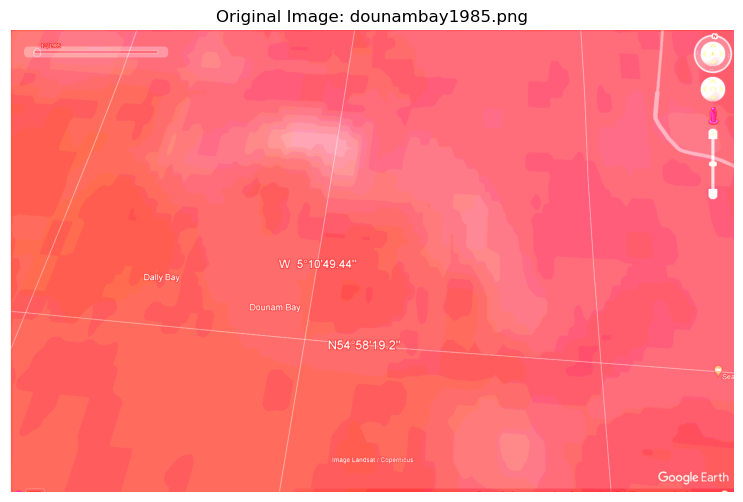

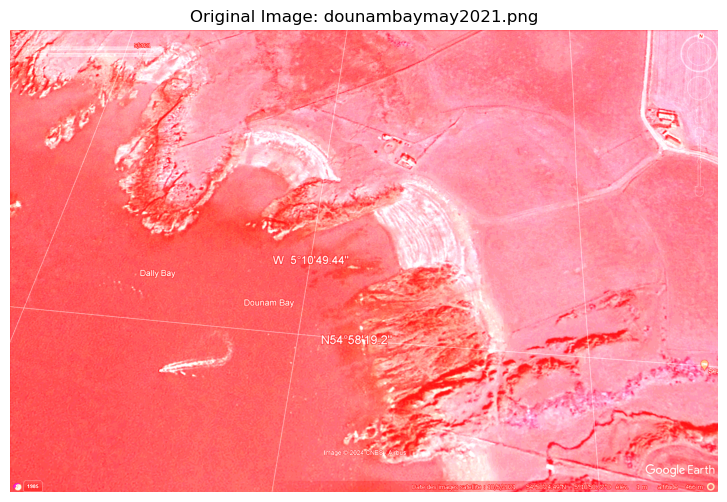

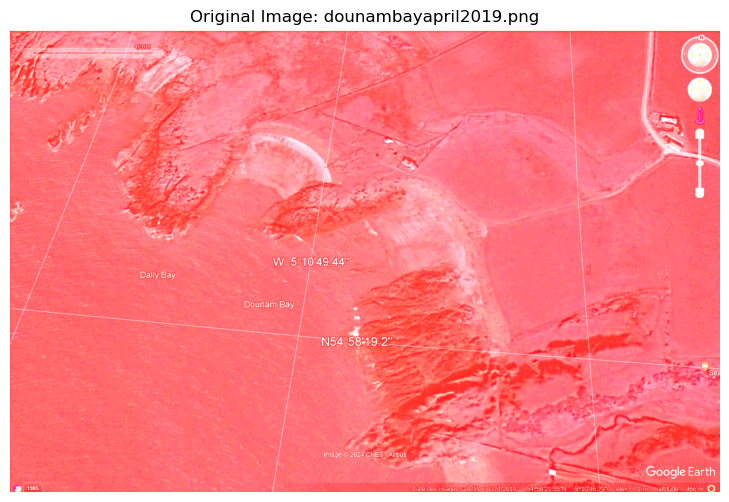

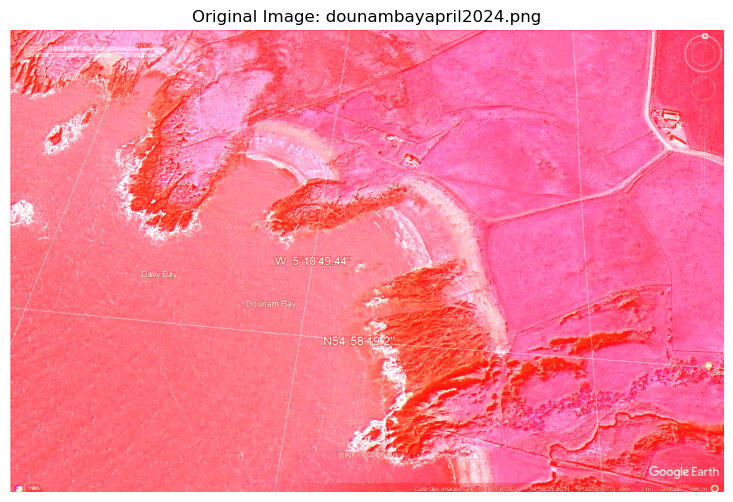

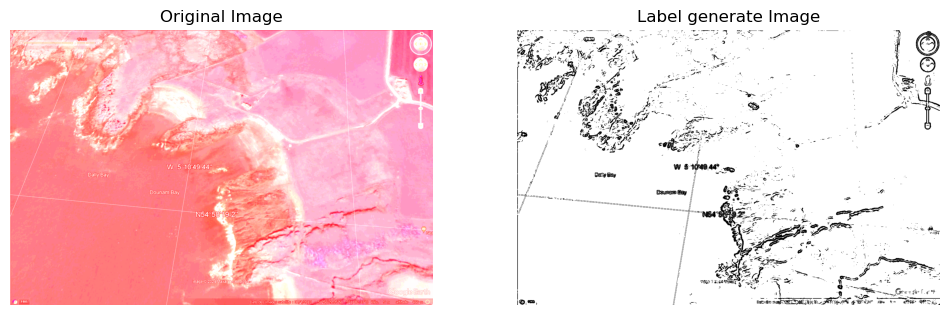

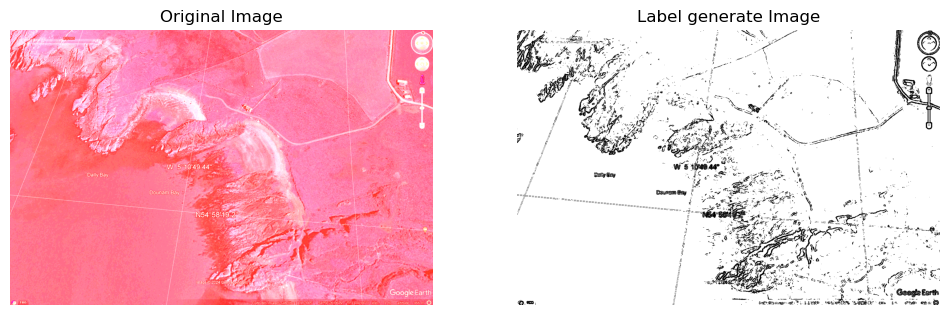

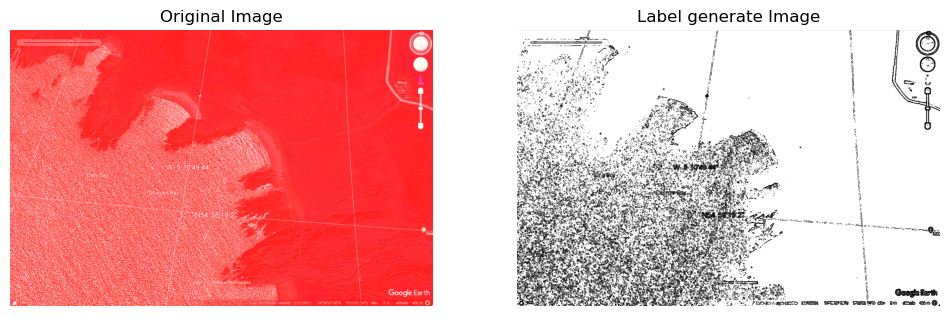

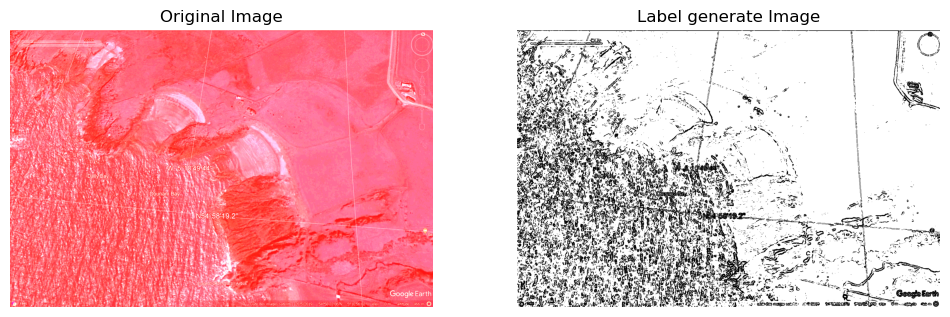

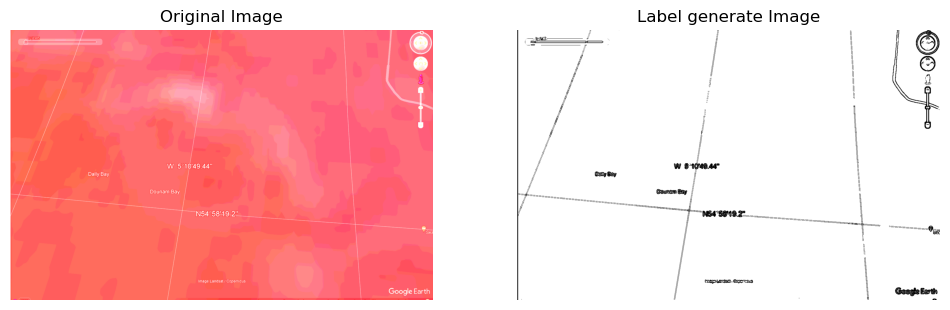

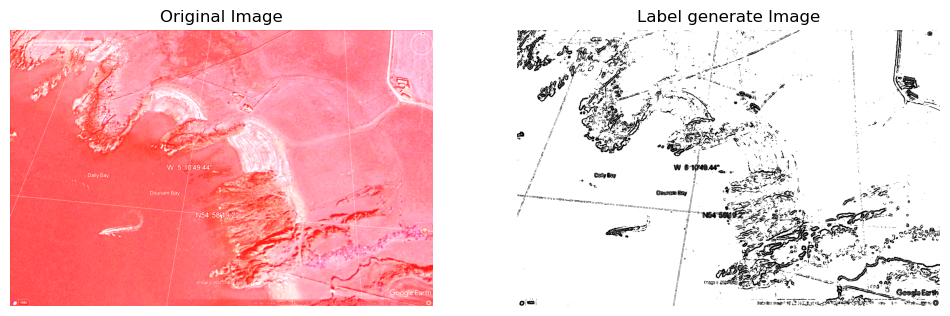

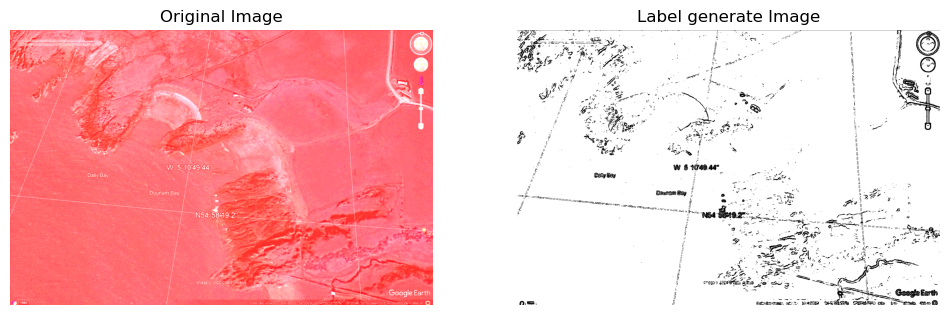

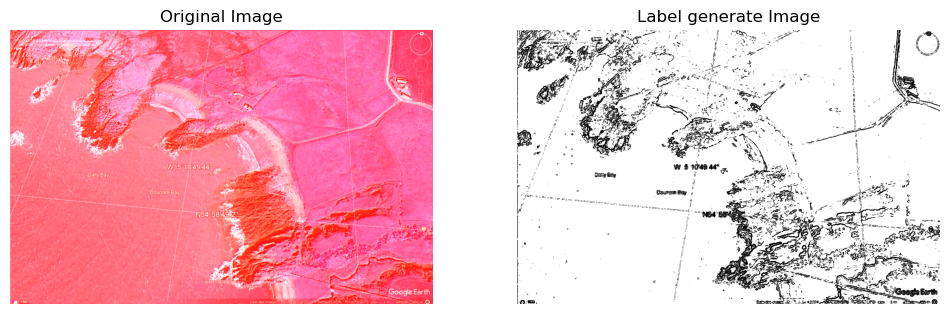

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
from osgeo import gdal

# Function to load and preprocess images
def load_test(path):
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    label_path = path.replace("images", "labels").replace("image", "label")
    label = gdal.Open(label_path).ReadAsArray() if os.path.exists(label_path) else None
    return stack_img, rgb_img, label

def get_rgb(img):
    """Return normalized RGB channels from sentinel image"""
    rgb_img = img[:, :, [3, 2, 1]]
    rgb_normalize = np.clip(rgb_img / 10000, 0, 0.3) / 0.3
    return (rgb_normalize * 255).astype(np.uint8)  # Convert to uint8

# Load images and labels
def load_data():
    test_path = glob.glob("../newdata/*.png")
    print(test_path[0])
    print(len(test_path))

    input_images = []
    rgb_images = []
    labels = []
    image_names = []

    for path in tqdm(test_path, desc="Loading data"):
        try:
            img, rgb_img, label = load_test(path)
            input_images.append(img)
            rgb_images.append(rgb_img)
            labels.append(label)
            image_names.append(os.path.basename(path))  # Store image name
        except Exception as e:
            print(f"Error with image {path}: {e}")

    return rgb_images, labels, image_names

# Function to normalize the image
def normalize_image(image):
    norm_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return norm_image.astype(np.uint8)

# Function to adjust brightness and contrast for better visualization
def adjust_brightness_contrast(image, brightness=30, contrast=30):
    return cv2.convertScaleAbs(image, alpha=1 + contrast / 100, beta=brightness)

# Display images without any processing
def display_images_without_processing(rgb_images, image_names):
    for rgb_image, image_name in zip(rgb_images, image_names):
        normalized_image = normalize_image(rgb_image)
        adjusted_image = adjust_brightness_contrast(normalized_image, brightness=20, contrast=20)
        plt.figure(figsize=(12, 6))
        plt.title(f'Original Image: {image_name}')
        plt.imshow(adjusted_image)
        plt.axis('off')
        plt.show()

# Function to generate label image based on Sobel edge detection
def generate_label(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Apply Sobel edge detection
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize the Sobel image to the range [0, 255]
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX)
    
    # Apply thresholding to get the binary label image
    _, label_image = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY_INV)
    
    return label_image

# Load and preprocess the data
rgb_images, labels, image_names = load_data()

# Display images without any processing
display_images_without_processing(rgb_images, image_names)

# Create output directory if it doesn't exist
output_dir = "../newdata/label_image_generate/"
os.makedirs(output_dir, exist_ok=True)

# Process each image and save the generated label
for rgb_image, image_name in zip(rgb_images, image_names):
    label_image = generate_label(rgb_image)
    output_path = os.path.join(output_dir, image_name.replace(".png", "_label_generate.png"))
    cv2.imwrite(output_path, label_image)

    # Display the original and label images
    normalized_image = normalize_image(rgb_image)
    adjusted_rgb_image = adjust_brightness_contrast(normalized_image, brightness=20, contrast=20)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(adjusted_rgb_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Label generate Image')
    plt.imshow(label_image, cmap='gray')
    plt.axis('off')

    plt.show()
